In [1]:
import tensorflow as tf  

if tf.config.list_physical_devices('GPU'): 

    print("GPU is available!") 
else:
    print("No GPU detected.")

GPU is available!


In [7]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = 'C:/Users/saivi/Downloads/horse2zebra/horse2zebra'

# Count the number of images in each folder
folders = ['trainA', 'trainB', 'testA', 'testB']
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    num_images = len(os.listdir(folder_path))
    print(f'Number of images in {folder}: {num_images}')

Number of images in trainA: 1067
Number of images in trainB: 1334
Number of images in testA: 120
Number of images in testB: 140


In [8]:
from PIL import Image

def check_image_sizes(folder_path):
    sizes = []
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            sizes.append(img.size)  
    return sizes

for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    image_sizes = check_image_sizes(folder_path)
    unique_sizes = set(image_sizes)  # Find unique sizes
    print(f'Unique image sizes in {folder}: {unique_sizes}')


Unique image sizes in trainA: {(256, 256)}
Unique image sizes in trainB: {(256, 256)}
Unique image sizes in testA: {(256, 256)}
Unique image sizes in testB: {(256, 256)}


In [ ]:
# Check the mode (color channels) and format of the images
def check_image_mode_format(folder_path):
    modes = []
    formats = []
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            modes.append(img.mode)  
            formats.append(img.format)  
    return set(modes), set(formats)

# Check for each folder
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    image_modes, image_formats = check_image_mode_format(folder_path)
    print(f'Image modes in {folder}: {image_modes}')
    print(f'Image formats in {folder}: {image_formats}')

In [9]:
def calculate_folder_size(folder_path):
    total_size = 0
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        total_size += os.path.getsize(image_path)  
    return total_size

# Calculate total dataset size
total_size = 0
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    folder_size = calculate_folder_size(folder_path)
    total_size += folder_size
    print(f'Total size of {folder}: {folder_size / (1024 * 1024):.2f} MB')

print(f'Total dataset size: {total_size / (1024 * 1024):.2f} MB')

Total size of trainA: 44.82 MB
Total size of trainB: 56.62 MB
Total size of testA: 4.88 MB
Total size of testB: 6.13 MB
Total dataset size: 112.44 MB


It looks like there is a significant imbalance between the number of images in the trainA (Horse) and trainB (Zebra) folders, with trainA having 1067 images and trainB having 1334 images. This imbalance might slightly affect the training process, especially for models like CycleGAN that expect roughly equal datasets for both domains to ensure effective learning.

However, there is no significant imbalance in the test set.

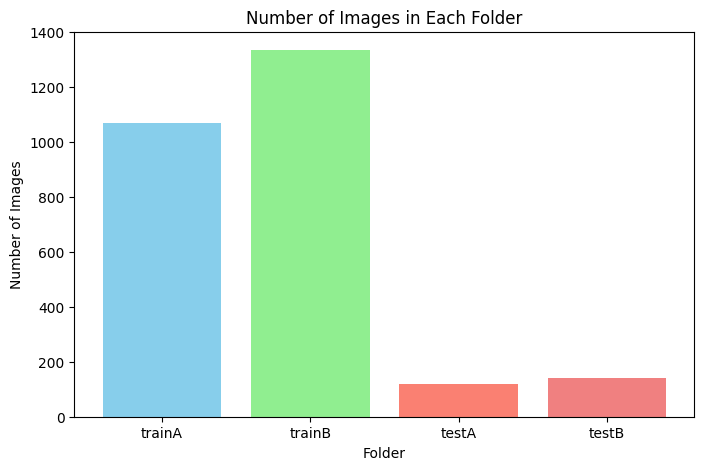

In [11]:
folder_names = list(image_stats.keys())
image_counts = [stats['num_images'] for stats in image_stats.values()]

# Plotting the number of images in each folder
plt.figure(figsize=(8, 5))
plt.bar(folder_names, image_counts, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.title('Number of Images in Each Folder')
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.show()


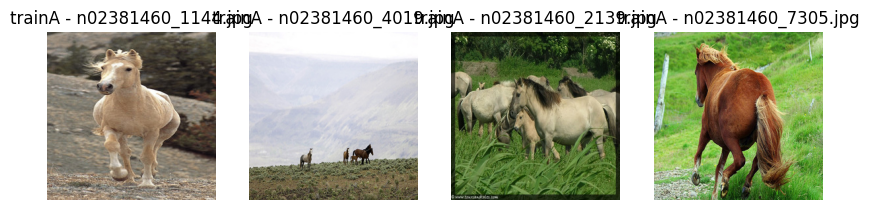

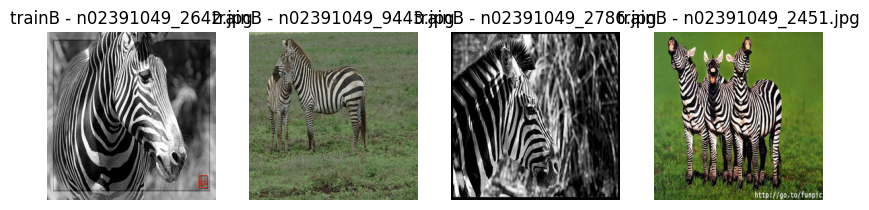

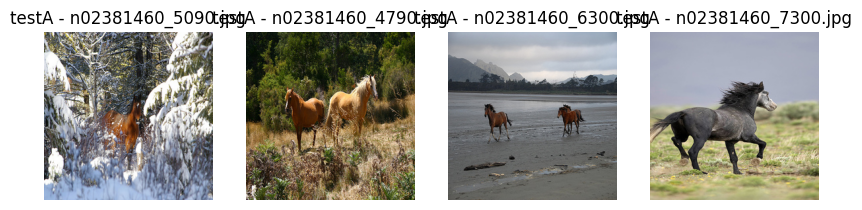

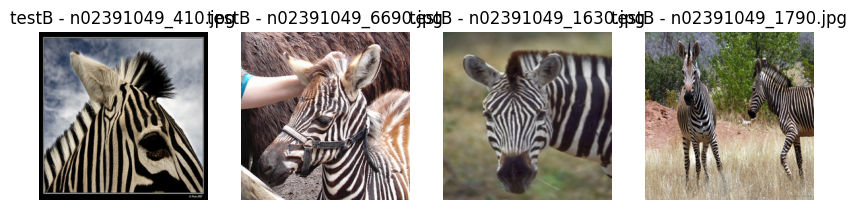

In [12]:
import random

def show_sample_images(data_dir, folder, num_samples=4):
    folder_path = os.path.join(data_dir, folder)
    images = os.listdir(folder_path)
    
    # Randomly select a few images
    selected_images = random.sample(images, num_samples)
    
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{folder} - {img_name}")
        plt.axis('off')
    plt.show()

# Visualize images from each folder
show_sample_images(data_dir, 'trainA')
show_sample_images(data_dir, 'trainB')
show_sample_images(data_dir, 'testA')
show_sample_images(data_dir, 'testB')

In [13]:
# Checking for imbalance by comparing image counts between folders
if abs(image_stats['trainA']['num_images'] - image_stats['trainB']['num_images']) > 100:
    print("Warning: There is a significant imbalance between the number of images in trainA and trainB.")
if abs(image_stats['testA']['num_images'] - image_stats['testB']['num_images']) > 50:
    print("Warning: There is a significant imbalance between the number of images in testA and testB.")
else:
    print("No significant imbalance found between image counts.")

No significant imbalance found between image counts.


In [16]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")  

        if self.transform:
            image = self.transform(image)

        return image

# Create datasets using the custom dataset class
trainA = CustomImageDataset(os.path.join(data_dir, 'trainA'), transform=transform)
trainB = CustomImageDataset(os.path.join(data_dir, 'trainB'), transform=transform)
testA = CustomImageDataset(os.path.join(data_dir, 'testA'), transform=transform)
testB = CustomImageDataset(os.path.join(data_dir, 'testB'), transform=transform)

# Create data loaders
trainA_loader = DataLoader(trainA, batch_size=1, shuffle=True)
trainB_loader = DataLoader(trainB, batch_size=1, shuffle=True)
testA_loader = DataLoader(testA, batch_size=1, shuffle=False)
testB_loader = DataLoader(testB, batch_size=1, shuffle=False)

print(f'TrainA batches: {len(trainA_loader)}, TrainB batches: {len(trainB_loader)}')
print(f'TestA batches: {len(testA_loader)}, TestB batches: {len(testB_loader)}')

TrainA batches: 1067, TrainB batches: 1334
TestA batches: 120, TestB batches: 140


Batch Shape: torch.Size([8, 3, 256, 256])
Image Range After Normalization: -1.0 1.0


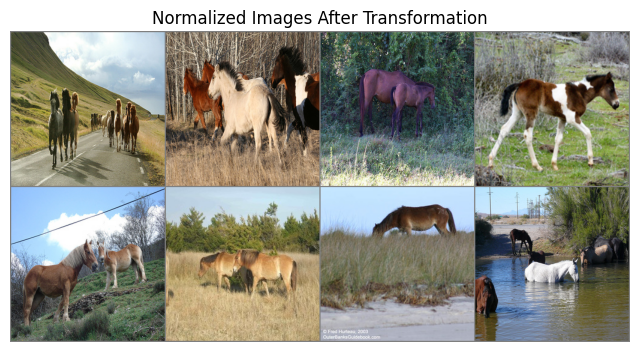

In [18]:
data_loader = DataLoader(trainA, batch_size=8, shuffle=True)

images = next(iter(data_loader))  
print("Batch Shape:", images.shape)  
print("Image Range After Normalization:", images.min().item(), images.max().item())  

def denormalize(tensor):
    return (tensor * 0.5) + 0.5  

# Visualize some images
grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(denormalize(grid.permute(1, 2, 0)).numpy())  
plt.title("Normalized Images After Transformation")
plt.axis("off")
plt.show()